Miryam Strautkalns

`CMPE-255. Spring 2024`

# Murder in the Orient Express

Hercules Poirot had it easy when he solved the murder in the Orient Express in 1934. He had to deal with only 12 suspects. Piece of cake.

In this exercise we'll use a more realistic situation (somehow...). A full train, with thousands of passengers, where most of them are potential suspects. Association Rules can help us narrow-down the number of suspects, so our sleuth can focus in a small group with high probability of being the murderer. We want to examine all passengers using Association Rules, and generate high probability rules that can help identify the culprit. Rules like the following, if they have high support and confidence, point to passengers that are more likely to have committed the crime:

```
{ Adult, Has access to first class, wears black shoes, owns a handkerchief } -> { seen walking around after midnight }
{ Male, Knows the victim, Owns a handkerchief } -> { Has access to 1st class }
```

For this homework, assume the current year is 2024.


## Goals of the exercise

1. Get familiar with Numpy and Pandas DataFrame
2. Get familiar with scikit-learn and other available AI and Data Mining packages
3. Practical hands-on experience in reviewing, cleaning, and preprocessing data
4. Practical hands-on experience on Association Rules


For this homework, assume current date is "2024".


# Setup

The following code includes common libraries, as well as functions for retrieving the data for this homework.

In [1]:
# Common Libraries - ADD as needed below
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

# install and import
!pip install apyori
from apyori import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
#

def debug_print(*args):
  #print("** DBG - ", *args)
  return

  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5953 sha256=7984d0b5eb79ab3d5da2c2e54c1d14e98eaecd06c18b9eb10fe1727289c33d94
  Stored in directory: /root/.cache/pip/wheels/c4/1a/79/20f55c470a50bb3702a8cb7c94d8ada15573538c7f4baebe2d
Successfully built apyori


In [ ]:
# Upload Dataset to colab
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving HW2 - Passengers.pickle to HW2 - Passengers (3).pickle
User uploaded file "HW2 - Passengers (3).pickle" with length 8977874 bytes


In [ ]:
# Useful functions

# Data Loading
def load_data(filename='HW2 - Passengers.pickle'):
  '''Load the data for the exercise into a Pandas DataFrame'''

  with open(filename, 'rb') as handle:
    return pd.DataFrame.from_dict(pickle.load(handle))

  print("ERROR: Unable to open file '%s'!" % filename)
  return None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# LOAD DATASET as a Panda Dataframe
passengers_df = load_data()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Test
passengers_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Id,Sex,Year of birth,Class,Has an alibi,Knows the victim,Owns a knife,Has access to 1st class,Owns a handkerchief,Wears black shoes,Seen after midnight
0,0,female,1965,3rd,no,yes,yes,yes,yes,yes,no
1,1,male,1943,3rd,yes,yes,yes,yes,yes,yes,yes
2,2,female,1974,2nd,no,yes,yes,yes,yes,no,no
3,3,male,2007,2nd,yes,yes,no,yes,yes,yes,no
4,4,male,1930,1st,yes,yes,no,yes,yes,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...
349995,349995,male,2006,3rd,yes,yes,yes,yes,yes,yes,yes
349996,349996,male,1984,3rd,yes,yes,yes,yes,no,yes,yes
349997,349997,male,1927,2nd,yes,yes,no,yes,yes,yes,yes
349998,349998,female,1933,3rd,yes,yes,no,yes,yes,no,yes


# 1. Understanding the Data



## 1.0. Review and understand the provided data
Review the pandas dataframe and its contents. Get familiar with the data provided and the contents. The data was collected from all passengers on-board, by asking each one of the passengers the following questions (possible answers shown in parenthesis):

* What is your Sex? (male/female)
* What is your year of birth? (year)
* What "class" is your ticket? ('1st', '2nd', '3rd', or 'employee')
* Did you know the victim? (yes/no)
* Do you own a pocket knife? (yes/no)
* Do you have access to 1st class? (yes/no)
* Do you own a handkerchief? (yes/no)
* Do you wear black shoes? (yes/no)
* Do you have an alibi for the time of the murder? (yes/no)
* Were you outside of your compartment after midnight? (yes/no)

## 1.1. Statistics and Visualization

### 1.1.1. Generate a histogram of "Year of birth" for each passenger
Use 10 bins, to accommodate ages from 1 to 100 years old, in intervals of 10 years.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


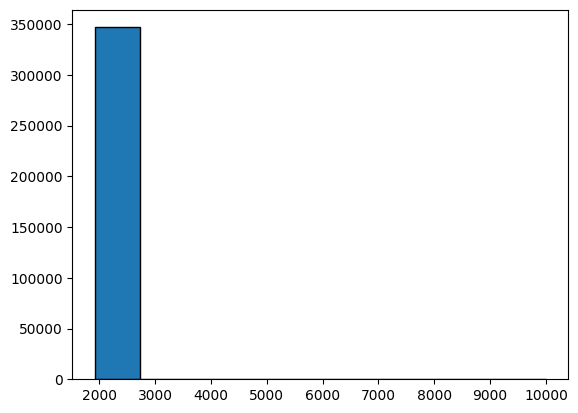

In [ ]:

passenger_hist = plt.hist(passengers_df["Year of birth"], bins=10, edgecolor='black')

### 1.1.2. Examine the results of the histogram
What is wrong with the histogram? What does it tell us about the "correctness" of the data?

The data for "Year of birth" was partially incorrect. Some data had dates greater than 2024, 2024 is considered the current year in the problem. I removed the rows with dates greater than 2024. Some dates were in the 9990's which is why there is such a large gap in the histogram between where the correct data is and the few entries that are incorrect.


### 1.1.3. Generate a table with the number of people in each "Class"
The table should include "1st", "2nd", "3rd" and "employee".


In [ ]:
# creates DataFrame with 1st, 2nd, 3rd, and employee values
accepted_classes = ["1st", "2nd", "3rd", "employee"]
passenger_by_class = passengers_df[passengers_df["Class"].isin(accepted_classes)]
passenger_by_class["Class"].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Class
3rd         129083
2nd         129055
1st          77441
employee     13024
Name: count, dtype: int64

### 1.1.4. Examine the results of the table
What is wrong with the table contents? Why the sum of all passengers in the table does not add up to the total number of passengers?
Review all the answers to the question "What 'class' is your ticket?" and generate a new table with the count for each answer. The total number of answers should now match the sum of all passenger. Identify the answers that are unexpected (i.e., answers that are not in the list ['1st', '2nd', '3rd', or 'employee']



In the list of unique values from the "Class" column there are values that wouldn't be included as a passenger. "luggage", "pet", "0", and nan are values that are excluded from the total number of passengers because they are not considered passengers/people. "4th" was excluded from the list requested. That is why the count for the table in 1.1.3 is less than that of the whole table of original data.

### 1.1.5. Generate a pie chart of responses to the question "Knows the victim"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


([<matplotlib.patches.Wedge at 0x7d1935b5e680>,
 [Text(-1.003119786769535, 0.4513875201990449, 'yes'),
  Text(1.0020473638269578, -0.45376324294442866, 'no'),
  Text(1.0999969119036919, -0.002606492344417862, 'Unknown')],
 [Text(-0.5471562473288372, 0.24621137465402446, '86.5%'),
  Text(0.5465712893601588, -0.24750722342423376, '13.4%'),
  Text(0.5999983155838319, -0.0014217230969551973, '0.1%')])

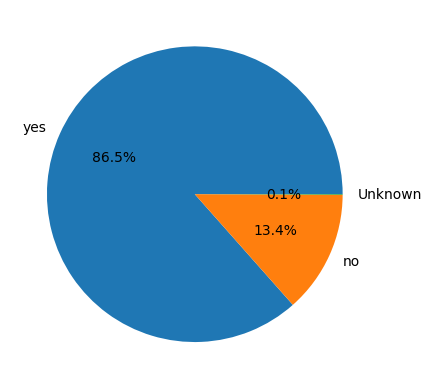

In [ ]:
# data set up for pie chart
values = passengers_df["Knows the victim"].value_counts().to_numpy()
labels = passengers_df["Knows the victim"].value_counts().index

fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%')

### 1.1.6. Examine the results of the chart
What is wrong with the pie chart?


The chart has some input listed as 'Unknown'. The chart is meant to assess the people who know the victim. 'Unknown' isn't useful. This is an error in the data that needs to be cleaned.

### 1.1.7. Unknown
Find out the columns in the data that include "Unknown" and the number of them. For this, examine the response to each question and count to entries where the answer is the word "Unknown".

In [ ]:
# function to count "Unknown" values in each column

def unknowncheck(passengers_df):
  accepted_classes = ["Unknown"]
  unknown_list = []
  print('Columns that contain \'Unknown\':\n')
  for col_name in passengers_df.columns:
    df_unknown_check = passengers_df[passengers_df[col_name].isin(["Unknown"])]
    if df_unknown_check.size > 0:
      print(df_unknown_check[col_name].value_counts(), "\n")
      unknown_list.append(col_name)

unknowncheck(passengers_df)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Columns that contain 'Unknown':

Has an alibi
Unknown    247
Name: count, dtype: int64 

Knows the victim
Unknown    264
Name: count, dtype: int64 

Owns a knife
Unknown    226
Name: count, dtype: int64 

Has access to 1st class
Unknown    226
Name: count, dtype: int64 

Owns a handkerchief
Unknown    248
Name: count, dtype: int64 

Wears black shoes
Unknown    281
Name: count, dtype: int64 

Seen after midnight
Unknown    258
Name: count, dtype: int64 



# 2. Data Pre-Processing -

From section 1, it is clear that there are three types of errors or inconsistencies in the original data, making "data clean-up" a necessary step. Once the dataset is clean, ir needs to be prepared for use with Association Rules algorithms.


## 2.1. Data Clean-up

In this section a new, clean, dataset will be created. The new dataset name should be "passengers_clean_df".

There were three types of errors identified in the data in section 1.

In [ ]:
passengers_clean_df = passengers_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* Error type 1, and approach to clean it up

First type of error is incorrect "birth year".
As this is a murder investigation, we want to fix this problem in such a way that we do not "reduce" the number of suspects. An easy way is to assume everybody is "an adult" (18 years or older).

So, for each incorrect entry, the data clean-up will be to set the passenger's birth date to the date for an adult. For instance, make all of them 20 years old.



### 2.1.1. Database clean-up

Generate a clean dataset by fixing the 3 types of errors described above. Place the new dataset in pandas DataFrame "passengers_clean_df"


### 2.1.2. Verify that the database has been cleaned up

Repeat the Histogram described in section 1.1.1, using the clean dataset. This Histogram should look correct.


### Cleaning Data - all years > 2024, will = 2006


### Histogram of "Year of birth" for each passenger
Use 10 bins, to accommodate ages from 1 to 100 years old, in intervals of 10 years.

All individuals that have incorrect data inputs will be set as an adult with a birth year of '2006'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


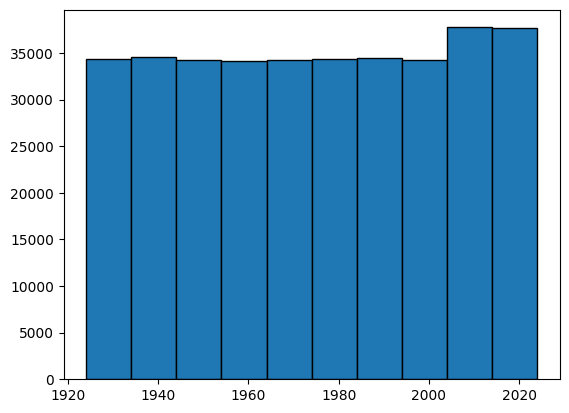

In [ ]:
# replaces all years greater than 2024 with 2006.
years = np.array(passengers_clean_df['Year of birth'].values.tolist())
passengers_clean_df['Year of birth'] = np.where(years > 2024, 2006, years).tolist()


passenger_hist1 = plt.hist(passengers_clean_df["Year of birth"], bins=10, edgecolor='black')



Below, the column "Class" is being cleaned so that all classifications are corrected to "1st".

In [ ]:
# if "Class" item not acceptable, it is replaced by "1st"

all_classes = passengers_clean_df["Class"].unique()
accepted_classes = ["1st", "2nd", "3rd", "employee"]
print('Check - \"Class\" column before cleaning, ', passengers_clean_df["Class"].unique(), '\n')
for val_item in all_classes:
  if val_item not in accepted_classes:
    passengers_clean_df['Class'] = passengers_clean_df["Class"].replace(val_item, '1st')

print('\nCheck - the \"Class\" column after, ', passengers_clean_df["Class"].unique())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Check - "Class" column before cleaning,  ['3rd' '2nd' '1st' 'employee' '4th' '0' 'luggage' 'pet'] 


Check - the "Class" column after,  ['3rd' '2nd' '1st' 'employee']


The next code section cleans the "Unknown" inputs, clarifies the 'yes' and 'no' answers for algorithms. "Unknown" values are chosen based on what an investigator would assume till information is cleared up.

Example: If it's unknown whether someone has an alibi, it should be assumed that the person doesn't have an alibi till convinced otherwise.

In [ ]:
# dict of values to replace 'Unknown', 'yes', and 'no' values
unknown_replacement = {'Has an alibi': 'No alibi', 'Knows the victim': 'Knows the victim', 'Owns a knife': 'Owns a knife', 'Has access to 1st class': 'Has access to 1st class', 'Owns a handkerchief': 'Owns a handkerchief', 'Wears black shoes': 'Wears black shoes', 'Seen after midnight': 'Was not seen after midnight'}
yes_replacement = {'Has an alibi': 'Has alibi', 'Knows the victim': 'Knows the victim', 'Owns a knife': 'Owns a knife', 'Has access to 1st class': 'Has access to 1st class', 'Owns a handkerchief': 'Owns a handkerchief', 'Wears black shoes': 'Wears black shoes', 'Seen after midnight': 'Seen after midnight'}
no_replacement = {'Has an alibi': 'No alibi', 'Knows the victim': 'Does not know the victim', 'Owns a knife': 'Does not own a knife', 'Has access to 1st class': 'Does not have access to 1st class', 'Owns a handkerchief': 'Does not own a handkerchief', 'Wears black shoes': 'Does not wear black shoes', 'Seen after midnight': 'Was not seen after midnight'}
# replaces column values for use in algorythm packages
for col_name in yes_replacement.keys():
  passengers_clean_df[col_name] = passengers_clean_df[col_name].replace('Unknown', unknown_replacement[col_name])
  passengers_clean_df[col_name] = passengers_clean_df[col_name].replace('yes', yes_replacement[col_name])
  passengers_clean_df[col_name] = passengers_clean_df[col_name].replace('no', no_replacement[col_name])

unknowncheck(passengers_clean_df)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Columns that contain 'Unknown':



## 2.2. Data Preparation for Association Rules

In order to prepare the dataset for identifying association rules, a transactions list must be created.

Define and create a transactions list that can be used for "Frequent Itemsets" generation (see section 3).

Before defining the format, review section 3 and identify the algorithms and packages that you will be using for analysis. Once the packages are identified, prepare the data here to match the input requirements for the algorithms.

# 3. Frequent Itemsets

Three algorithms were introduced in the lectures: APriori, FP Growth, and ECLAT. In this section we will select two of the three algorithms, and apply them to the transactions dataset to extract Frequent Itemsets. You can use any of the publicly available packages that include those algorithms.


## 3.1. Select and apply two algorithms
Select two of the three algorithms discusses in class: APriori, FP Growth, and ECLAT.
Identify an opensource python package that include the selected algorithms, and apply both algorithms to generate frequent itemsets. You will have to choose, at a minimum, a "minsup" value for generating the frequent itemsets. Explore different "minsup" values as you work towards have a short list of rules in section 4 below.


# **APriori:**

In [ ]:
# convert to string for Apriori package
passengers_clean_df = passengers_clean_df.astype(str)
pass_list = passengers_clean_df.values.tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rules = apriori(pass_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
results = list(rules)
results_list = {}
for i in range(0, len(results)):
    results_list[i] = [results[i][1], results[i][0]]
sorted_dict = dict(sorted(results_list.items(), key=lambda item: item[1]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



## 3.2. List the top 10 itemsets with the highest support
List the top 10 frequent itemsets with the highest support from one of the two selected algorithms above.


In [ ]:
print('- Top Ten frequent itemsets -\n')

removed_num = len(sorted_dict) - 10
list_num = 10
for item in sorted_dict:
  if removed_num == 0:
    print(list_num, ':\nSupport: ', sorted_dict[item][0], '\nItemset: ', sorted_dict[item][1], '\n')
    list_num -= 1
  else:
    removed_num = removed_num - 1

- Top Ten frequent itemsets -

10 :
Support:  0.6940485714285715 
Itemset:  frozenset({'Has access to 1st class', 'Wears black shoes'}) 

9 :
Support:  0.7032142857142857 
Itemset:  frozenset({'Seen after midnight'}) 

8 :
Support:  0.7304714285714285 
Itemset:  frozenset({'Wears black shoes'}) 

7 :
Support:  0.74412 
Itemset:  frozenset({'Has access to 1st class', 'Owns a handkerchief', 'Knows the victim'}) 

6 :
Support:  0.7829428571428572 
Itemset:  frozenset({'Owns a handkerchief', 'Knows the victim'}) 

5 :
Support:  0.82322 
Itemset:  frozenset({'Has access to 1st class', 'Knows the victim'}) 

4 :
Support:  0.8591114285714285 
Itemset:  frozenset({'Has access to 1st class', 'Owns a handkerchief'}) 

3 :
Support:  0.86616 
Itemset:  frozenset({'Knows the victim'}) 

2 :
Support:  0.9043085714285715 
Itemset:  frozenset({'Owns a handkerchief'}) 

1 :
Support:  0.9500485714285715 
Itemset:  frozenset({'Has access to 1st class'}) 



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **FP Growth**

In [ ]:
# data setup for algorithm

dataset = passengers_clean_df.values
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
fp_support = fpgrowth(df, min_support=0.35, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



## 3.2. List the top 10 itemsets with the highest support
List the top 10 frequent itemsets with the highest support from one of the two selected algorithms above.


Order: From the most to the least

In [ ]:
print('Top Ten:')
print(fp_support.sort_values(by=['support'], ascending=False)[:10])

Top Ten:
     support                                           itemsets
0   0.950049                          (Has access to 1st class)
1   0.904309                              (Owns a handkerchief)
2   0.866160                                 (Knows the victim)
13  0.859111     (Has access to 1st class, Owns a handkerchief)
14  0.823220        (Has access to 1st class, Knows the victim)
15  0.782943            (Owns a handkerchief, Knows the victim)
16  0.744120  (Has access to 1st class, Owns a handkerchief,...
3   0.730471                                (Wears black shoes)
8   0.703214                              (Seen after midnight)
17  0.694049       (Has access to 1st class, Wears black shoes)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 3.3. Compare runtime between the 2 selected algorithms
**When running the selected algorithms, compare their runtime.**


The runtime shows up next to the field, I isolated each line of code that uses each algorithm for calculating support. It took the APriori 14 minutes to complete. FP Growth took aproximately 2 minutes to complete.

# 4. Rules - APriori

Generate rules. List rules by confidence. You can use any of the publicly available python packages that include algorithms to generate rules.


## 4.1. Apply an algorithm to create rules based on the frequent itemsets from the previous section

Select one of the two algorithms in section 3 to move to rule generation. Identify an opensource python package that can generate rules and proceed to generate them. The main parameter to use in generating rules should be "confidence", but you can use other parameters as well by explaining why you'd prefer to use them instead of "confidence".

Iterate between section 3.2 and 4.1 to fine-tune the selection of "minsup" and "confidence" until you get a reasonable set of rules.


## 4.2. Display the top 10 rules, by confidence

With your final selected "minsup" and "confidence", generate and display the top 10 rules by "confidence".


Which includes all the itemsets from the support lists.

In [ ]:
!pip install efficient-apriori
from efficient_apriori import apriori

# convert to list of tuples for APriori algorithm package
pass_list =[tuple(row) for row in passengers_clean_df.values.tolist()]

itemsets, rules = apriori(pass_list, min_support=0.17, min_confidence=0.951)
print('Top Ten Rules with highest Confidence:\n')
print(len(rules), 'total rules')
for rule in rules:
  print(rule)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top Ten Rules with highest Confidence:

10 total rules
{Knows the victim, Owns a knife, male} -> {Has access to 1st class} (conf: 0.951, supp: 0.247, lift: 1.001, conv: 1.023)
{Owns a knife, Wears black shoes, male} -> {Has access to 1st class} (conf: 0.951, supp: 0.209, lift: 1.001, conv: 1.021)
{3rd, Knows the victim, Owns a handkerchief, Seen after midnight} -> {Has access to 1st class} (conf: 0.951, supp: 0.194, lift: 1.001, conv: 1.020)
{Has alibi, Knows the victim, Owns a handkerchief, male} -> {Has access to 1st class} (conf: 0.951, supp: 0.234, lift: 1.001, conv: 1.021)
{Has alibi, Knows the victim, Seen after midnight, male} -> {Has access to 1st class} (conf: 0.951, supp: 0.182, lift: 1.001, conv: 1.022)
{Knows the victim, Owns a handkerchief, Owns a knife, male} -> {Has access to 1st class} (conf: 0.951, supp: 0.224, lift: 1.001, conv: 1.020)
{Knows the victim, Owns a knife, Seen after midnight, male} -> {Has access to 1st class} (conf: 0.951, supp: 0.174, lift: 1.001, conv:

# 5. Solving the murder

Now that we have determined frequent itemsets and rules, it is time to generate information that can be useful to identify key suspects in the murder case.

Start by using the following "antecedents" to a rule:

{'Has access to 1st class', 'Adult', 'Owns a handkerchief'}

then generate rules that meet the criteria. You may need to adjust the support and/or confidence in the previous sections to get a pool of items large enough.

Once you have identified rules that meet the above antecedents, find at least one passenger that could be a suspect. Please note that the main two reasons for discarding a suspect are: "Has an alibi", and is not and "Adult".



# Choices made:

Filtered Out -
*   "Has an alibi"
*   Not "Adults"








In [ ]:

# removing "Has an alibi", and is not an "Adult"
passengers_clean_df1 = pd.DataFrame(passengers_clean_df)
passengers_clean_df1['Year of birth'] = passengers_clean_df1['Year of birth'].astype('int64')


filtered_values = np.where((passengers_clean_df1["Year of birth"] < 2007) & (passengers_clean_df1["Has an alibi"].str.startswith('N')))
murder_suspects = passengers_clean_df1.iloc[filtered_values]
print("Total Suspects: ", len(murder_suspects), '\n')


# (conf: 0.951, supp: 0.209, lift: 1.001, conv: 1.021)
print('Rule 1: {Owns a knife, Wears black shoes, male} -> {Has access to 1st class} ')
filtered_values = np.where((murder_suspects["Owns a knife"].str.startswith('O')) & (murder_suspects["Wears black shoes"].str.startswith('W')) & (murder_suspects["Sex"].str.startswith('m')) & (murder_suspects["Has access to 1st class"].str.startswith('H')))
murder_rule1 = murder_suspects.iloc[filtered_values]
print("total suspects after rule 1: ", len(murder_rule1), '\n')

# (conf: 0.951, supp: 0.163, lift: 1.001, conv: 1.016)
print('Rule 2: {Owns a handkerchief, Owns a knife, male, no alibi} -> {Has access to 1st class}')
filtered_values = np.where((murder_rule1["Owns a handkerchief"].str.startswith('O')) & (murder_rule1["Owns a knife"].str.startswith('O')) & (murder_rule1["Sex"].str.startswith('m')) & (murder_rule1["Has access to 1st class"].str.startswith('H')))
murder_rule2 = murder_rule1.iloc[filtered_values]
print("total suspects after rule 2: ", len(murder_rule2), '\n')

# (conf: 0.951, supp: 0.194, lift: 1.001, conv: 1.020)
print('Rule 3: {3rd, Knows the victim, Owns a handkerchief, Seen after midnight} -> {Has access to 1st class}')
filtered_values = np.where((murder_rule2["Class"].str.startswith('3')) & (murder_rule2["Owns a handkerchief"].str.startswith('O')) & (murder_rule2["Knows the victim"].str.startswith('K')) & (murder_rule2["Seen after midnight"].str.startswith('S'))  & (murder_rule2["Has access to 1st class"].str.startswith('H')))
murder_rule3 = murder_rule2.iloc[filtered_values]
print("total suspects after rule 3: ", len(murder_rule3), '\n')


# print(murder_rule3.iloc[[0]])



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total Suspects:  106177 

Rule 1: {Owns a knife, Wears black shoes, male} -> {Has access to 1st class} 
total suspects after rule 1:  22345 

Rule 2: {Owns a handkerchief, Owns a knife, male, no alibi} -> {Has access to 1st class}
total suspects after rule 2:  20243 

Rule 3: {3rd, Knows the victim, Owns a handkerchief, Seen after midnight} -> {Has access to 1st class}
total suspects after rule 3:  4567 



Using the frequent itemsets with the highest support, the list from the highest confidence, and the rules that were created below, I chose these three rules to narrow down the suspects.

**Rule 1:** {Owns a handkerchief, Was not seen after midnight, Wears black shoes, no alibi} -> {Knows the victim}

**Rule 2:** {Owns a handkerchief, Owns a knife, male, no alibi} -> {Has access to 1st class}

**Rule 3:** {3rd, Knows the victim, Owns a handkerchief, Seen after midnight} -> {Has access to 1st class}

These three rules filter the list down to the smallest count the group of suspects can be reduced, 4567 suspects.

**The suspect has been categorized to:**

male, Adult, 3rd class, No alibi, Knows the victim, Owns a knife, Has access to 1st class, Owns a handkerchief, Wears black shoes, Seen after midnight

(Adjusted Rules Code is last, first ten is printed in loop. Entire printed list is commented out due to length)

In [ ]:

itemsets, rules = apriori(pass_list, min_support=0.4, min_confidence=0.95)
print('Murder Solving! :\n')
print(len(rules), 'ten rules')


for rule in rules:
  print(rule)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Murder Solving! :

25 ten rules
{Has alibi} -> {Has access to 1st class} (conf: 0.950, supp: 0.600, lift: 1.000, conv: 1.000)
{Knows the victim} -> {Has access to 1st class} (conf: 0.950, supp: 0.823, lift: 1.000, conv: 1.008)
{Owns a handkerchief} -> {Has access to 1st class} (conf: 0.950, supp: 0.859, lift: 1.000, conv: 0.999)
{Wears black shoes} -> {Has access to 1st class} (conf: 0.950, supp: 0.694, lift: 1.000, conv: 1.002)
{male} -> {Has access to 1st class} (conf: 0.950, supp: 0.474, lift: 1.000, conv: 1.008)
{Has alibi, Knows the victim} -> {Has access to 1st class} (conf: 0.950, supp: 0.520, lift: 1.000, conv: 1.008)
{Has alibi, Owns a handkerchief} -> {Has access to 1st class} (conf: 0.950, supp: 0.543, lift: 1.000, conv: 1.002)
{Has alibi, Seen after midnight} -> {Has access to 1st class} (conf: 0.950, supp: 0.422, lift: 1.000, conv: 1.001)
{Has alibi, Wears black shoes} -> {Has access to 1st class} (conf: 0.950, supp: 0.439, lift: 1.000, conv: 0.999)
{Knows the victim, Owns